## Goal

There are multiple solutions here used rolling mean and lags as features and lots of them turned out pretty useful. So what is the optimal rolling mean and lags in this case?

Here I used catboost to build a basic model and analyzed it by 

* Feature Importance
* SHAP value
* Model analysis plot

(Note: to avoid memory error, a few parameters and data scope has been modified. )


## Referenced Notebook 

**Most of the code on feature engineering are from this notebook by @kkiller: **
https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50

Also referenced: 


https://www.kaggle.com/mayer79/m5-forecast-poisson-loss


https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed


In [4]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
from catboost import Pool, CatBoostRegressor
#import lightgbm as lgb

In [5]:
import pandas as pd
import shap

In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.style.use('fivethirtyeight')

In [8]:
pd.options.display.max_columns = 50

In [9]:
CAL_DTYPES={"weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16"}
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [10]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [11]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [12]:
## modified from the original
def create_fea(dt, lags, windows):
    print("creating window: ", windows, " lag: ", lags)
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    for win in windows :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())


    ## drop lag col
    dt.drop(lag_cols, axis=1, inplace=True)
    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [13]:
#FIRST_DAY = 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !
# I used 350 as the first day 
# To avoid maxing out the memory
FIRST_DAY = 1000

In [14]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.columns

CPU times: user 27.7 s, sys: 8.41 s, total: 36.1 s
Wall time: 36.2 s


Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26600086 entries, 0 to 26600085
Data columns (total 22 columns):
id              object
item_id         int16
dept_id         int16
store_id        int16
cat_id          int16
state_id        int16
d               object
sales           float32
date            datetime64[ns]
wm_yr_wk        int16
weekday         int16
wday            int16
month           int16
year            int16
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA         int64
snap_TX         int64
snap_WI         int64
sell_price      float32
dtypes: datetime64[ns](1), float32(2), int16(10), int64(3), object(6)
memory usage: 2.9+ GB


In [16]:
df.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis=1,\
       inplace=True)

In [17]:
gc.collect()

0

In [18]:
%%time
create_fea(df, lags=[7,14, 28, 30, 50, 60], windows=[7, 28])
df.shape

creating window:  [7, 28]  lag:  [7, 14, 28, 30, 50, 60]
CPU times: user 8min 31s, sys: 35.1 s, total: 9min 6s
Wall time: 9min 6s


(26600086, 30)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26600086 entries, 0 to 26600085
Data columns (total 30 columns):
id             object
item_id        int16
dept_id        int16
store_id       int16
cat_id         int16
state_id       int16
d              object
sales          float32
date           datetime64[ns]
wm_yr_wk       int16
weekday        int16
wday           int16
month          int16
year           int16
sell_price     float32
rmean_7_7      float32
rmean_14_7     float32
rmean_28_7     float32
rmean_30_7     float32
rmean_50_7     float32
rmean_60_7     float32
rmean_7_28     float32
rmean_14_28    float32
rmean_28_28    float32
rmean_30_28    float32
rmean_50_28    float32
rmean_60_28    float32
week           int16
quarter        int16
mday           int16
dtypes: datetime64[ns](1), float32(14), int16(13), object(2)
memory usage: 2.8+ GB


In [20]:
# X_train.corr()

## Split train and validation

In [21]:
df.dropna(inplace = True)
df.shape

(23947579, 30)

In [22]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id']
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [23]:
X_train.shape

(23947579, 24)

In [24]:
%%time

np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, int(X_train.shape[0]*.2), replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

CPU times: user 2.96 s, sys: 307 ms, total: 3.27 s
Wall time: 3.27 s


## (Auto)correlation between features

In [25]:
fake_valid_inds_2 = np.random.choice(X_train.index.values, int(X_train.shape[0]*.002), replace = False)


In [26]:
import seaborn as sns

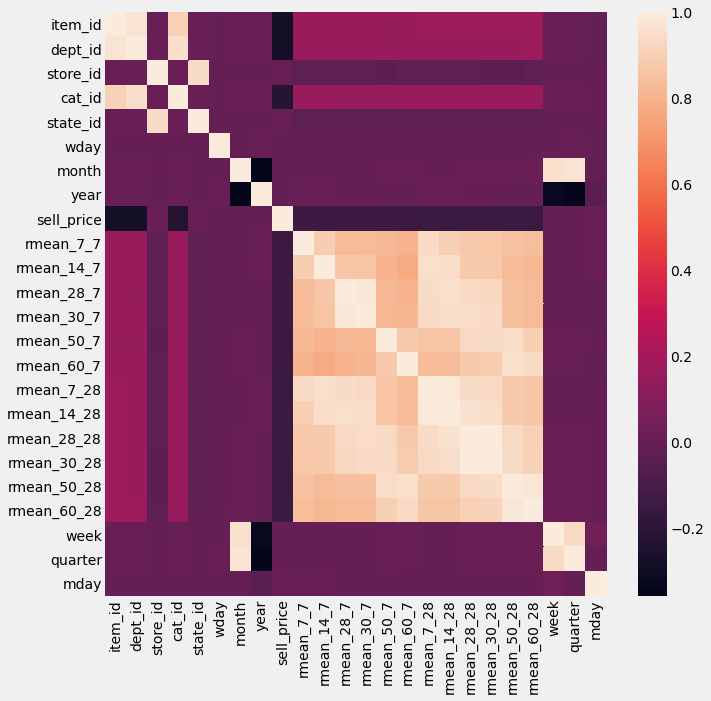

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.loc[fake_valid_inds_2].corr())

In [28]:
gc.collect()

5

## Catboost

In [29]:
## load model
from catboost import Pool, CatBoostRegressor

from_file = CatBoostRegressor()
model = from_file.load_model('../input/catboost-baseline/catboost_model_0430')


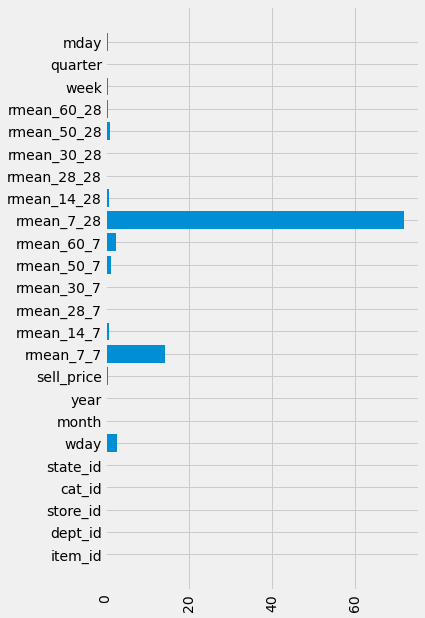

CPU times: user 8min 19s, sys: 3.34 s, total: 8min 23s
Wall time: 8min 16s


In [33]:
%%time

####### I uploaded the model to avoid memory error
cat_feats_ind = [i for (i, j) in enumerate(X_train.columns) if j in cat_feats]

# # put in pool
train_pool = Pool(X_train.loc[train_inds], y_train.loc[train_inds], cat_features=cat_feats_ind)
test_pool = Pool(X_train.loc[fake_valid_inds], y_train.loc[fake_valid_inds], cat_features=cat_feats_ind)

# # train
# # I used iteration = 80 and depths = 3 at first
# model =CatBoostRegressor(iterations=80, \
#                       depth=3, \
#                       learning_rate=1, \
#                       loss_function='RMSE',l2_leaf_reg=1)


###############################################################


#model.fit(train_pool, eval_set=test_pool, verbose=False)

# plot
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,10))
plt.barh(train_pool.get_feature_names(), model.get_feature_importance())
plt.xticks(rotation=90)
plt.show()


In [53]:
gc.collect()

218461

In [35]:
feature_df = pd.DataFrame({'Feature': X_train.columns, "Imp": model.get_feature_importance()})

In [36]:
feature_df.sort_values('Imp', ascending=False)

,Feature,Imp
15,rmean_7_28,71.670428
9,rmean_7_7,14.422479
5,wday,2.849679
14,rmean_60_7,2.547648
13,rmean_50_7,1.386668
19,rmean_50_28,1.177313
16,rmean_14_28,0.972732
10,rmean_14_7,0.910807
23,mday,0.598944
21,week,0.577751


## Prediction

In [37]:
cat_feats_ind = [i for (i, j) in enumerate(X_train.columns) if j in cat_feats]

In [38]:
cat_feats_ind

[0, 1, 2, 3, 4]

In [39]:
gc.collect()

4697

In [40]:
def create_lag_features_for_test(dt, day, lags, windows):
    # modified the original 
    # create lag feaures just for single day (faster)
    #lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt.loc[dt.date == day, lag_col] = \
            dt.loc[dt.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    #windows = [7, 28]
    for window in windows:
        for lag in lags:
            df_window = dt[(dt.date <= day-timedelta(days=lag)) & (dt.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(dt.loc[dt.date==day,'id'])
            dt.loc[dt.date == day,f"rmean_{lag}_{window}"] = \
                df_window_grouped.sales.values     

In [41]:
def create_date_features_for_test(dt):
    # copy of the code from `create_dt()` above
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(
                dt["date"].dt, date_feat_func).astype("int16")

In [42]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)  # equal weights

te0 = create_dt(False)  # create master copy of `te`
create_date_features_for_test (te0)

CPU times: user 10.4 s, sys: 1.39 s, total: 11.8 s
Wall time: 11.8 s


In [43]:
model = model
for icount, (alpha, weight) in enumerate(zip(alphas, weights)):
    te = te0.copy()  # just copy
    cols = [f"F{i}" for i in range(1, 29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day.date())
        tst = te[(te.date >= day - timedelta(days=max_lags))
                 & (te.date <= day)].copy()
#         create_fea(tst)  # correct, but takes much time
        create_lag_features_for_test(tst, day, lags=[7], windows=[7])  # faster  
        tst = tst.loc[tst.date == day, train_cols]
        
        ## put tst in pool
        tst_pool = Pool(data=tst, cat_features=cat_feats_ind)
        te.loc[te.date == day, "sales"] = \
            alpha * model.predict(tst_pool)  # magic multiplier by kyakovlev

    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()

    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")[
        "id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F"]).unstack()[
        "sales"][cols].reset_index()
    te_sub.fillna(0., inplace=True)
    te_sub.sort_values("id", inplace=True)
    te_sub.reset_index(drop=True, inplace=True)
    te_sub.to_csv(f"submission_{icount}.csv", index=False)
    if icount == 0:
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_catboost_add_iteration_04_27.csv",index=False)
#print(icount, alpha, weight)

0 2016-04-25



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


1 2016-04-26
2 2016-04-27
3 2016-04-28
4 2016-04-29
5 2016-04-30
6 2016-05-01
7 2016-05-02
8 2016-05-03
9 2016-05-04
10 2016-05-05
11 2016-05-06
12 2016-05-07
13 2016-05-08
14 2016-05-09
15 2016-05-10
16 2016-05-11
17 2016-05-12
18 2016-05-13
19 2016-05-14
20 2016-05-15
21 2016-05-16
22 2016-05-17
23 2016-05-18
24 2016-05-19
25 2016-05-20
26 2016-05-21
27 2016-05-22
0 2016-04-25



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


1 2016-04-26
2 2016-04-27
3 2016-04-28
4 2016-04-29
5 2016-04-30
6 2016-05-01
7 2016-05-02
8 2016-05-03
9 2016-05-04
10 2016-05-05
11 2016-05-06
12 2016-05-07
13 2016-05-08
14 2016-05-09
15 2016-05-10
16 2016-05-11
17 2016-05-12
18 2016-05-13
19 2016-05-14
20 2016-05-15
21 2016-05-16
22 2016-05-17
23 2016-05-18
24 2016-05-19
25 2016-05-20
26 2016-05-21
27 2016-05-22
0 2016-04-25
1 2016-04-26
2 2016-04-27
3 2016-04-28
4 2016-04-29
5 2016-04-30
6 2016-05-01
7 2016-05-02
8 2016-05-03
9 2016-05-04
10 2016-05-05
11 2016-05-06
12 2016-05-07
13 2016-05-08
14 2016-05-09
15 2016-05-10
16 2016-05-11
17 2016-05-12
18 2016-05-13
19 2016-05-14
20 2016-05-15
21 2016-05-16
22 2016-05-17
23 2016-05-18
24 2016-05-19
25 2016-05-20
26 2016-05-21
27 2016-05-22


In [55]:
del sub,sub2

NameError: name 'sub' is not defined

## Shap values

Shape values explain how far each feature 'pushes' the target values to larger or smaller values.


See [this link](https://github.com/slundberg/shap) for details.

In [44]:
gc.collect()

12

In [45]:
shap_values = model.get_feature_importance(tst_pool,type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [46]:
# we used one of the test data for shap value calculation
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], tst.iloc[3,:])

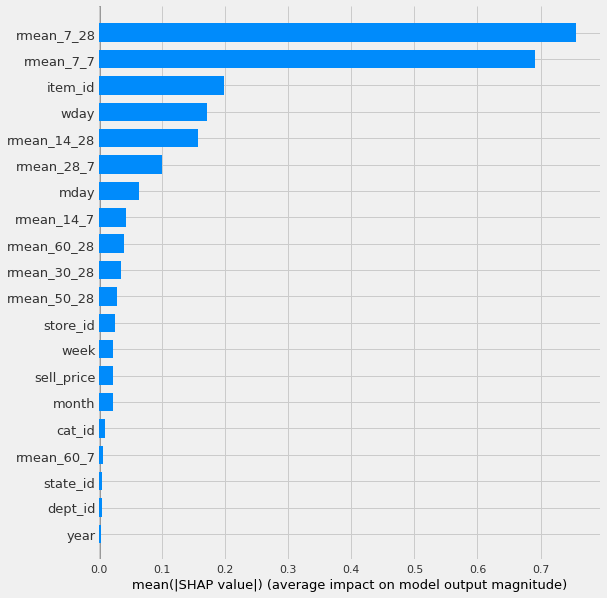

CPU times: user 379 ms, sys: 167 ms, total: 547 ms
Wall time: 298 ms


In [47]:
%%time
shap.summary_plot(shap_values, tst, plot_type='bar')


You can see the SHAP value has a different interpretation than the feature importance.

## Model Analysis Plots

Catboost has a special way of plotting features to help you understand **how dispersed each feature has and the discrepancy between predicted value and true value**.

See this [link](https://catboost.ai/docs/concepts/python-reference_catboostregressor_calc_feature_statistics.html) for detail explanation.

In [48]:
feature = ['rmean_7_7', 'rmean_7_28', 'rmean_60_7', 'rmean_50_7', 'rmean_50_28',\
           'rmean_14_7','rmean_14_28', 'rmean_28_7']

In [50]:
X_train.shape

(23947579, 24)

In [52]:
model.calc_feature_statistics(X_train[23940000:], y_train[23940000:],feature=feature, plot=True)

{'rmean_7_7': {'borders': array([7.1428575e-02, 3.5714287e-01, 1.2142857e+00, 2.2142859e+00,
         3.0714285e+00, 3.7857141e+00, 4.5000000e+00, 5.7857141e+00,
         6.9285717e+00, 7.5000000e+00, 1.0357143e+01, 1.0928572e+01,
         1.3785714e+01, 1.6357143e+01, 2.1785713e+01, 2.9214287e+01,
         2.9500000e+01, 3.3357140e+01, 3.6357140e+01, 4.3500000e+01,
         5.1642860e+01, 6.5714279e+01, 7.7857147e+01, 9.5571426e+01,
         1.1028571e+02, 1.2200000e+02], dtype=float32),
  'binarized_feature': array([3, 2, 2, ..., 2, 0, 0]),
  'mean_target': array([  0.33254343,   0.4551597 ,   0.8659924 ,   1.6361724 ,
           2.407792  ,   3.088785  ,   4.0238094 ,   4.614379  ,
           6.8404255 ,   5.290323  ,   7.136752  ,   9.909091  ,
          12.511111  ,  12.67742   ,  13.21875   ,  23.755556  ,
          30.        ,  31.9       ,  26.        ,  35.625     ,
          50.285713  ,  47.        ,   0.        , 131.        ,
           0.        ,   0.        ,   0.     

## Summary

* Feature Importance: rmean_7_28 > rmean_7_7 > rmean_60_7 > rmean_50_7 > rmean_50_28
* SHAP value: rmean_7_28 > rmean_7_7 > rmean_14_28 > rmean_28_7 > rmean_14_7
* model plot analysis: rmean_7_28 > rmean_7_7 > rmean_14_28 > rmean_50_28 > rmean_14_7